<a href="https://colab.research.google.com/github/HyeonuJeong/Mycakd5/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%91%EC%9A%A9_0520_%EB%AC%B8%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 프로젝트 기반 빅데이터 서비스 솔루션 개발 전문 과정

#### 교과목명: 딥러닝 응용
- 평가일:
- 성명:
- 점수:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Q1. mnist datasets를 불러와서 PyTorch 프레임워크으로 다음을 수행하세요.
- 생성자 및 판별자 클래스 정의 및 학습데이터 불러오기
- 모델 학습 및 샘플링
 - 학습을 위한 생성자와 판매자 모델 초기화
 - 적절한 하이퍼 파라미터 설정(lr = 0.0002, betas=(0.5, 0.999))
 - 모델을 학습하면서 주기적으로 샘플링하여 결과 확인(n_epochs = 200, sample_interval = 2000)
- 생성된 이미지 예시 출력 

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

latent_dim = 100

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()


    def block(input_dim, output_dim, normalize=True):
      layers = [nn.Linear(input_dim, output_dim)]
      if normalize:
        layers.append(nn.BatchNorm1d(output_dim,0.8))
      layers.append(nn.LeakyReLU(0.2,inplace=True))
      return layers

    self.model = nn.Sequential(
        *block(latent_dim, 128,normalize=False),
        *block(128,256),
        *block(256,512),
        *block(512,1024),
        nn.Linear(1024,1*28*28),
        nn.Tanh()
    )

  def forward(self,z):
    img = self.model(z)

    img = img.view(img.size(0), 1, 28, 28)
    return img

In [3]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator,self).__init__()

    self.model = nn.Sequential(
        nn.Linear(1*28*28,512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(256,1),
        nn.Sigmoid(),
    )

 
  def forward(self, img):
    flattened = img.view(img.size(0),-1)
    output = self.model(flattened)
    return output

In [4]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset = datasets.MNIST(root='./dataset', train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

lr = 0.0002


optimizer_G = torch.optim.Adam(generator.parameters(),lr=lr, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))

In [6]:
import time

n_epochs = 200
sample_interval = 2000
start_time = time.time()

for epoch in range(n_epochs):
  for i, (imgs,_) in enumerate(dataloader):

    real = torch.cuda.FloatTensor(imgs.size(0),1).fill_(1.0)
    fake = torch.cuda.FloatTensor(imgs.size(0),1).fill_(0.0)

    real_imgs = imgs.cuda()

    optimizer_G.zero_grad()

    z = torch.normal(mean=0,std=1,size=(imgs.shape[0], latent_dim)).cuda()   

    generated_imgs = generator(z)

    g_loss = adversarial_loss(discriminator(generated_imgs), real)

    g_loss.backward()
    optimizer_G.step()

    optimizer_D.zero_grad()

    real_loss = adversarial_loss(discriminator(real_imgs), real)
    fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    optimizer_D.step()

    done = epoch*len(dataloader) + i
    if done % sample_interval == 0:
      save_image(generated_imgs.data[:25], f'{done}.png', nrow=5, normalize=True)
  

  print(f'[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/200] [D loss: 0.431961] [G loss: 0.731499] [Elapsed time: 13.01s]
[Epoch 1/200] [D loss: 0.416151] [G loss: 0.988416] [Elapsed time: 26.08s]
[Epoch 2/200] [D loss: 0.391732] [G loss: 1.608512] [Elapsed time: 38.13s]
[Epoch 3/200] [D loss: 0.281589] [G loss: 2.083786] [Elapsed time: 50.04s]
[Epoch 4/200] [D loss: 0.153049] [G loss: 2.412922] [Elapsed time: 62.19s]
[Epoch 5/200] [D loss: 0.355472] [G loss: 3.157787] [Elapsed time: 74.03s]
[Epoch 6/200] [D loss: 0.595099] [G loss: 3.425050] [Elapsed time: 86.79s]
[Epoch 7/200] [D loss: 0.158946] [G loss: 2.113618] [Elapsed time: 104.21s]
[Epoch 8/200] [D loss: 0.333712] [G loss: 1.005795] [Elapsed time: 122.29s]
[Epoch 9/200] [D loss: 0.141132] [G loss: 2.529953] [Elapsed time: 136.25s]
[Epoch 10/200] [D loss: 0.287174] [G loss: 2.755489] [Elapsed time: 148.75s]
[Epoch 11/200] [D loss: 0.317107] [G loss: 0.901295] [Elapsed time: 161.18s]
[Epoch 12/200] [D loss: 0.145879] [G loss: 2.135014] [Elapsed time: 173.53s]
[Epoch 13/200] [

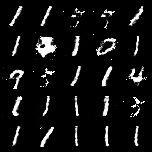

In [8]:
from IPython.display import Image
Image('92000.png')

Q2. 아래사항을 참조하여 로드된 ECG 데이터를 활용하여 이상치 감지 모델을 만든 후 성능 평가를 수행하세요.

[ECG5000 데이터세트]에서 이상을 감지하도록 autoencoder를 훈련합니다. 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 [심전도]가 포함되어 있습니다. 단순화 된 버전의 데이터세트를 사용하고, 각 예제는 `0`(비정상 리듬에 해당) 또는 `1`(정상 리듬에 해당)으로 레이블이 지정됩니다. 

autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다. autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다. 여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다. 그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Download the dataset
import pandas as pd

dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


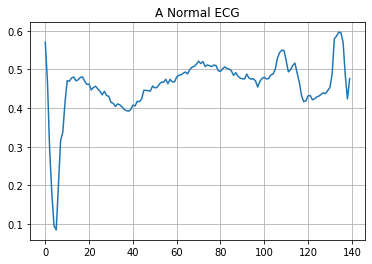

In [10]:
labels = raw_data[:,-1]
data = raw_data[:,0:-1]
train_data,test_data,train_labels,test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val-min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data,tf.float32)
test_data = tf.cast(test_data, tf.float32)




train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title('A Normal ECG')
plt.show()

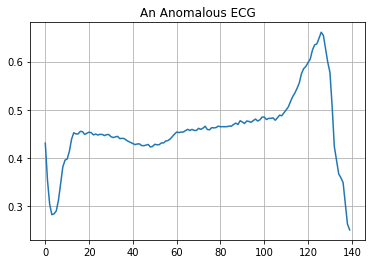

In [11]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title('An Anomalous ECG')
plt.show()

In [12]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32,activation='relu'),
      layers.Dense(16,activation='relu'),
      layers.Dense(8,activation='relu')                                  
    ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation='relu'),
      layers.Dense(32, activation='relu'), 
      layers.Dense(140, activation='sigmoid')                                   
    ])
  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded 

autoencoder = AnomalyDetector()

In [13]:
autoencoder.compile(optimizer='adam',loss='mae')

In [14]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                         epochs=20,
                         batch_size=512,
                         validation_data=(test_data,test_data),
                         shuffle=True)

Epoch 1/20
5/5 [==============================] - 4s 39ms/step - loss: 0.0581 - val_loss: 0.0536
Epoch 2/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0567 - val_loss: 0.0523
Epoch 3/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0548 - val_loss: 0.0509
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0522 - val_loss: 0.0493
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0490 - val_loss: 0.0477
Epoch 6/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0456 - val_loss: 0.0457
Epoch 7/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0421 - val_loss: 0.0441
Epoch 8/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0386 - val_loss: 0.0423
Epoch 9/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0354 - val_loss: 0.0410
Epoch 10/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0329 - val_loss: 0.0398
Epoch 11/20
5/5 [=====================

In [15]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

threshold = np.mean(train_loss) + np.std(train_loss)


In [16]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions,data)
  return tf.math.less(loss, threshold)

def print_stats(predictions,labels):
  print('Accuracy = {}'.format(accuracy_score(labels,preds)))
  print('Precision = {}'.format(precision_score(labels,preds)))
  print('Recall ={}'.format(recall_score(labels,preds)))

In [17]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds,test_labels)

Accuracy = 0.942
Precision = 0.9921568627450981
Recall =0.9035714285714286


Q3. YOLOv5를 활용하고 포트홀 데이터로 파인튜닝하여 "포트홀 탐지모델"을 개발하고 테스트 데이터 샘플에 대하여 포트홀 탐지가 되는지 확인하세요.

YOLOv5 : https://github.com/ultralytics/yolov5.git<br>
포트홀 데이터 : https://public.roboflow.com/object-detection/pothole

In [18]:
%cd /content
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
from IPython.display import Image, clear_output

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 13599, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 13599 (delta 87), reused 102 (delta 71), pack-reused 13476
Receiving objects: 100% (13599/13599), 12.11 MiB | 30.53 MiB/s, done.
Resolving deltas: 100% (9492/9492), done.
/content/yolov5
     |████████████████████████████████| 596 kB 5.3 MB/s 


In [19]:
%mkdir /content/yolov5/pothole
%cd /content/yolov5/pothole

/content/yolov5/pothole


In [20]:
!curl -L "https://public.roboflow.com/ds/iUa0xBDOFB?key=INHutojAfw" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1991      0 --:--:-- --:--:-- --:--:--  1986
100 46.0M  100 46.0M    0     0  57.2M      0 --:--:-- --:--:-- --:--:-- 57.2M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg  
 extracting: test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg  
 extracting: test/images/img-146_jpg.rf.61be25b3053a51f622a244980545df2b.jpg  
 extracting: test/images/img-161_jpg.rf.211541e7178a4a93ec0680f26b905427.jpg  
 extracting: test/images/img-168_jpg.rf.af3590e07b06b43e91fa53990ff94af3.jpg  
 extracting: test/images/img-179_jpg.rf.8632eb0d9b75fefe144829e67b75015a.jpg  
 extracting: test/images/img

In [21]:
from glob import glob

train_img_list = glob('/content/yolov5/pothole/train/images/*.jpg')
test_img_list = glob('/content/yolov5/pothole/test/images/*.jpg')
valid_img_list = glob('/content/yolov5/pothole/vaild/images/*.jpg')
print(len(train_img_list),len(test_img_list))

465 67


In [22]:
import yaml
with open('/content/yolov5/pothole/train.txt','w') as f:
  f.write('\n'.join(train_img_list)+'\n')

with open('/content/yolov5/pothole/test.txt','w') as f:
  f.write('\n'.join(test_img_list)+'\n')

with open('/content/yolov5/pothole/vaild.txt','w') as f:
  f.write('\n'.join(valid_img_list)+'\n')

In [23]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [24]:
%%writetemplate /content/yolov5/pothole/data.yaml
train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']

In [25]:
%cat /content/yolov5/pothole/data.yaml

train: ./pothole/train/images
test: ./pothole/test/images
val: ./pothole/valid/images

nc: 1
names: ['pothole']

In [26]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [27]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [29]:
%%time
%cd /content/yolov5/


!python train.py --img 640 --batch 32 --epochs 100 --data ./pothole/data.yaml --cfg ./models/custom_yolov5s.yaml --weight '' --name pothole_result --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=./pothole/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=pothole_result, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-204-gf43cd53 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_g

In [30]:
!python detect.py --weights /content/yolov5/runs/train/pothole_result/weights/best.pt --img 640 --conf 0.4 --source ./pothole/test/images

detect: weights=['/content/yolov5/runs/train/pothole_result/weights/best.pt'], source=./pothole/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-204-gf43cd53 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/67 /content/yolov5/pothole/test/images/img-105_jpg.rf.3fe9dff3d1631e79ecb480ff403bcb86.jpg: 640x640 1 pothole, Done. (0.013s)
image 2/67 /content/yolov5/pothole/test/images/img-107_jpg.rf.2e40485785f6e5e2efec404301b235c2.jpg: 640x640 1 pothole, Done. (0.013s)
image 3/67 /content/yolov5/pothole/test/images/img-146_

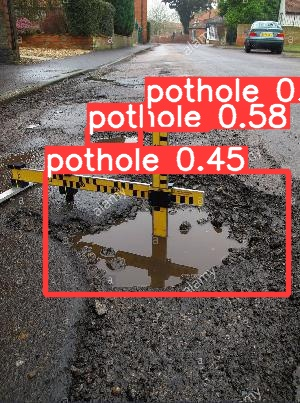

In [32]:
import glob
import random 
from IPython.display import Image, display

image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp/*.jpg'))
display(Image(filename=image_name))

Q4~5. 주어진 네이버 댓글 데이터 ratings_train.txt, ratings_test.txt 를 활용하여 아래 요구사항에 따라 감성분석 모델 생성 및 평가를 수행하세요.
- pre-trained model로 kobert 사용
- pre-trained model로 bert multilingual 사용

In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install sacremoses

In [36]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
from tqdm import tqdm
import os
import re
import sentencepiece as spm

In [37]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 12.41 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [38]:
train = pd.read_table('nsmc/' + 'ratings_train.txt')
test = pd.read_table('nsmc/'+'ratings_test.txt')
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [43]:
from google.colab import files 
files.upload()

Saving tokenization_kobert.py to tokenization_kobert.py


{'tokenization_kobert.py': b'# coding=utf-8\r\n# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team and Jangwon Park\r\n#\r\n# Licensed under the Apache License, Version 2.0 (the "License");\r\n# you may not use this file except in compliance with the License.\r\n# You may obtain a copy of the License at\r\n#\r\n#     http://www.apache.org/licenses/LICENSE-2.0\r\n#\r\n# Unless required by applicable law or agreed to in writing, software\r\n# distributed under the License is distributed on an "AS IS" BASIS,\r\n# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\r\n# See the License for the specific language governing permissions and\r\n# limitations under the License.\r\n""" Tokenization classes for KoBert model."""\r\n\r\n\r\nimport logging\r\nimport os\r\nimport unicodedata\r\nfrom shutil import copyfile\r\n\r\nfrom transformers import PreTrainedTokenizer\r\n\r\n\r\nlogger = logging.getLogger(__name__)\r\n

In [ ]:
from transformers import BertModel, DistilBertModel
bert_model = BertModel.from_pretrained('monologg/kobert')
distilbert_model = DistilBertModel.from_pretrained('monologg/distilkobert')

In [ ]:
from tokenization_kobert import KoBertTokenizer
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

In [ ]:
from tokenization_kobert import KoBertTokenizer
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

In [47]:
def convert_data(data_df):
  global tokenizer
  SEQ_LEN = 64

  tokens, masks, segments, targets = [],[],[],[]

  for i in tqdm(range(len(data_df))):
    token = tokenizer.encode(data_df[DATA_COLUMN][i], truncation=True, padding='max_length',max_length=SEQ_LEN)
    num_zeros = token.count(0)
    mask = [1] * (SEQ_LEN-num_zeros) + [0] * num_zeros
    segment = [0] * SEQ_LEN

    tokens.append(token)
    masks.append(mask)
    segments.append(segment)

    targets.append(data_df[LABEL_COLUMN][i])

  tokens = np.array(tokens)
  masks = np.array(masks)
  segments = np.array(segments)
  targets = np.array(targets)

  return [tokens, masks, segments], targets

In [48]:
def load_data(pandas_dataframe):
  data_df = pandas_dataframe
  data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
  data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
  data_x,data_y = convert_data(data_df)
  return data_x, data_y

SEQ_LEN = 64
BATCH_SIZE = 32
DATA_COLUMN = 'document'
LABEL_COLUMN = 'label'

train_x, train_y = load_data(train)

100%|██████████| 150000/150000 [00:41<00:00, 3621.57it/s]


In [49]:
test_x, test_y = load_data(test)

100%|██████████| 50000/50000 [00:14<00:00, 3511.71it/s]


In [50]:


model = TFBertModel.from_pretrained('monologg/kobert', from_pt=True)
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')

bert_output = model([token_inputs, mask_inputs, segment_inputs])

loading configuration file https://huggingface.co/monologg/kobert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8002
}

loading weights file https://huggingface.co/monologg/kobert/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9525d

In [51]:
bert_output = bert_output[1]
bert_output.shape

TensorShape([None, 768])

In [52]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [53]:
import tensorflow_addons as tfa
opt = tfa.optimizers.RectifiedAdam(lr=5.0e-5, total_steps=2344*2,warmup_proportion=0.1, min_lr=1e-5,epsilon=1e-08, clipnorm=1.0)

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [54]:
sentiment_drop = tf.keras.layers.Dropout(0.5)(bert_output)
sentiment_first = tf.keras.layers.Dense(1,activation='sigmoid',kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(sentiment_drop)
sentiment_model = tf.keras.Model([token_inputs,mask_inputs,segment_inputs],sentiment_first)
sentiment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [55]:
sentiment_model.fit(train_x,train_y,epochs=2,shuffle=True,batch_size=64,validation_data=(test_x,test_y))

Epoch 1/2
2344/2344 [==============================] - 2368s 990ms/step - loss: 0.3677 - accuracy: 0.8245 - val_loss: 0.2725 - val_accuracy: 0.8858
Epoch 2/2
2344/2344 [==============================] - 2314s 987ms/step - loss: 0.2308 - accuracy: 0.9069 - val_loss: 0.2535 - val_accuracy: 0.8972


In [56]:
sentiment_model.evaluate(test_x,test_y)

1563/1563 [==============================] - 231s 148ms/step - loss: 0.2535 - accuracy: 0.8972


[0.2535359263420105, 0.8972399830818176]